In [ ]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 597 (delta 10), reused 2 (delta 1), pack-reused 569
Receiving objects: 100% (597/597), 57.73 MiB | 33.23 MiB/s, done.
Resolving deltas: 100% (298/298), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.30.2
Using datasets v2.13.1
Using accelerate v0.21.0
Using sentencepiece v0.1.99
Using umap v0.5.3
No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.


텍스트 분류는 NLP에서 매우 일반적인 작업이다.  
감성 분석 또한 이의 일부이며 매우 유용한다.  

</br>
이 장에서는 BERT의 한 종류인 DistilBERT를 사용해 구현해보겠다.  

</br>
또한 허깅페이스의 핵심 라이브러리인 데이터셋, 토크나이저, 트랜스포머를 사용해 보겠다.


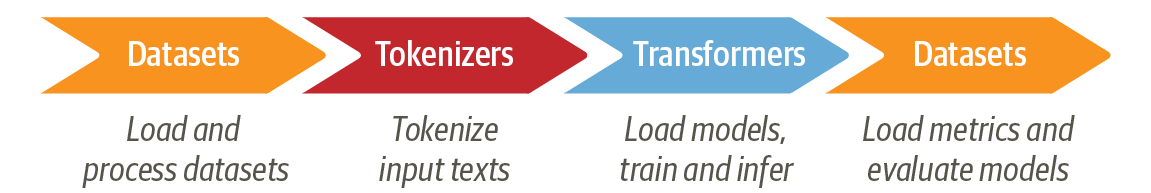

---
# 데이터 셋
긍정적과 부정적으로 나뉘는 대부분의 감정 분석과는 달리  
이번에 사용할 데이터 셋은 분노, 혐오, 두려움, 기쁨, 슬픔, 놀람  
6개의 감정을 사용하는 데이터 셋을 사용한다.  



In [ ]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있다.")
print(f"처음 10개 데이터 셋 : {all_datasets[:10]}")

<ipython-input-2-5c4ff1dcd749>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


현재 허브에는 46240개의 데이터셋이 있다.
처음 10개 데이터 셋 : ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


데이터셋마다 이름이 있다. load_dataset()함수로 emotion 데이터 셋을 로드해보자

In [ ]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

이 emotions라는 객체는 파이썬 딕셔너리와 비슷한다.  
각 키는 다른 분할에 상응하며 일반적인 딕셔너리 사용법을 사용할 수 있다.

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

Dataset 클래스 객체를 반환했다.

In [ ]:
len(train_ds)

16000

출력 결과, 길이는 16000, 위에도 나와있다.  
인덱스로 개별 샘플을 참조해보자

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

한 개의 행이 하나의 딕셔너리로 표현된다.  
0번째 샘플은 i didnt feel humiliated  
즉, 나는 굴욕감을 느끼지 않았다. 라는 의미를 가진다.  

In [ ]:
train_ds.column_names

['text', 'label']

앞의 개별 샘플이 text와 label로 구분된 것 처럼  
출력 결과도 text와 label인 것을 볼 수 있는데  
이는 트윗과 감정을 의미한다.  

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


위 출력을 통해 라벨에 어떤 감정을 의미하는지 알 수 있다.  
아까 0번 샘플의 label값은 0이었는데, 이는 sadness를 의미하는 것으로 보인다.  

이제, 샘플을 여러개 가져와보자

In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


5개의 샘플을 가져왔다.  
내용은 다음과 같다.(전부 번역기 결과다.)  

나는 굴욕감을 느끼지 않았다.

나는 단지 관심을 갖고 깨어있는 누군가의 곁에 있는 것만으로도 매우 절망적인 기분에서 빌어먹을 희망으로 바뀔 수 있다.  

나는 게시하기 위해 1분을 잡고 있다. 나는 욕심이 잘못되었다고 느낀다.  

나는 벽난로에 대해 향수를 느끼고 있다. 나는 그것이 여전히 부동산에 있다는 것을 알게 될 것이다.  

나는 기분이 언짢다.

</br>
이에 대하여, 감정은 각각
슬픔, 슬픔, 분노, 사랑, 분노  
로 분류되었다.  
(사실 번역기 결과가 매끄럽지가 않아서, 이게 맞는 분류인지는 잘 모르겠다.)  


# 데이터 프레임
데이터 셋 객체를 판다스의 DataFrame으로 변환하는 것이 편리할 때가 많다.  
변환해보자  

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


앞의 데이터 셋이 판다스에 맞게 출력되었다.  
그런데 라벨이 숫자이면 보기 불편하므로 감정을 적어보자  


In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


본격적으로 분류모델을 만들기 전에 이 데이터 셋에 대해서 좀 더 깊게 알아보자  
샘플 데이터를 쓰기 전에, 이 데이터 셋이 어떤지를 조사하는 것은 중요하므로  
항상 어떤 데이터인지 알아보고 쓰도록 하자  

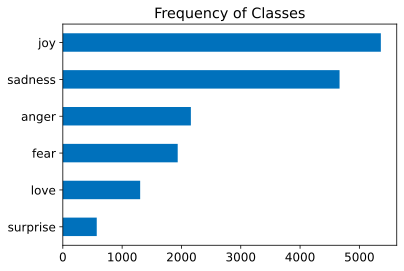

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

이 데이터 셋은 상당히 편향적이다.  
joy와 sadness만 많이 등장하고 love나 surprise는 적다.  
이러한 불균형은 오버 샘플링이나 언더 샘플링으로 그 수를 맞춰줄 수 있지만  
여기서는 그냥 쓰도록 하겠다.  


## 길이 확인
트랜스포머 모델에는 최대 문맥 크기라는 시퀸스 길이가 있다.  
최대 문맥 크기는 512토큰으로 문단 몇 개 정도가 된다.  
참고로 토큰은 텍스트의 기본 단위다.  
트윗당 단어 분포를 통해 감정에 따른 트윗 길이가 대략 추정된다.  


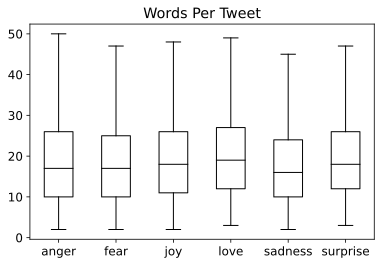

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

감정별 트윗의 길이는 대략 15개 정도이다.  

In [ ]:
# 리셋용
emotions.reset_format()

## 텍스트에서 토큰으로
주어진 텍스트를 토큰화 해보자  


In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


글자단위로 쪼개긴 했지만 모델은 각 문자가 정수로 변환되리라 기대한다.  
이런 과정을 수치화 라고 한다.  
가장 쉬운 방법은 고유한 각 토큰을 고유한 정수로 인코딩 하는 것이다.  

In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


이제 이걸 정수리스트로 변환한다.

In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


토큰들이 저마다 고유 숫자 식별자로 매핑 되었다.  
이번엔 고유명사를 매핑해보자

In [ ]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


이 방식은 이름사이에 가상의 순서가 만들어 진다는 문제가 있다.  
따라서 다음과 같은 방법을 사용한다.  

In [ ]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


이것이 바로 원핫 벡터이다.  
하나만 1이며 나머지는 0이다.  
원소 사이에 순서가 있는건 매한가지지만 별다른 의미가 없어진다.  
</br>

원핫 인코딩을 만들어보자

In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

38개의 입력 토큰에 각각 20차원의 원핫 벡터가 만들어졌다.  
첫 번째 벡터를 조사해보자

In [ ]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


토큰은 T, 인덱스는 5인 것을 알 수 있다.  

이 방식은 철자 오류나 희귀 단어를 처리하는데 유용하지만  
단어 같은 언어 구조를 이 데이터에서 학습해야 한다는 단점이 있고  
이를 위해 엄청난 양의 컴퓨터 자원이 요구된다.  
때문에 이 방식은 거의 사용되지 않는다.  
</br>

대신 단어 토큰화를 사용해보자

---
### 단어 토큰화

글자 단위 대신 공백을 기준으로 텍스트를 토큰화 한다.  

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


텍스트가 쪼개진 것을 볼 수 있다.  
그러나 구두점이 고려되지 않아서 NLP.이 하나의 토큰으로 처리된다.  
만약 오타, 활용형 등이 있다면 토큰의 수는 엄청나게 불어날 것이다.  
이로인해 어휘사전이 커지면 신경망 파라미터도 역시 많이 필요해진다.  

</br>
이걸 보안하기 위해 부분단어 토큰화를 사용한다.

---
### 부분단어 토큰화
문자 토큰화와 단어 토큰화의 장점을 결합한 방법이다.  


In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


---
# 전체 데이터셋 토큰화

먼저 샘플을 토큰화할 처리 함수가 필요하다.

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


패딩 결과를 보면 첫 요소가 두 번째 요소보다 더 짧으므로 길이를 맞추기 위해
끝에 0을 추가한다.
0은 어휘사전에 있는 PAD 토큰에 해당한다.

In [ ]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


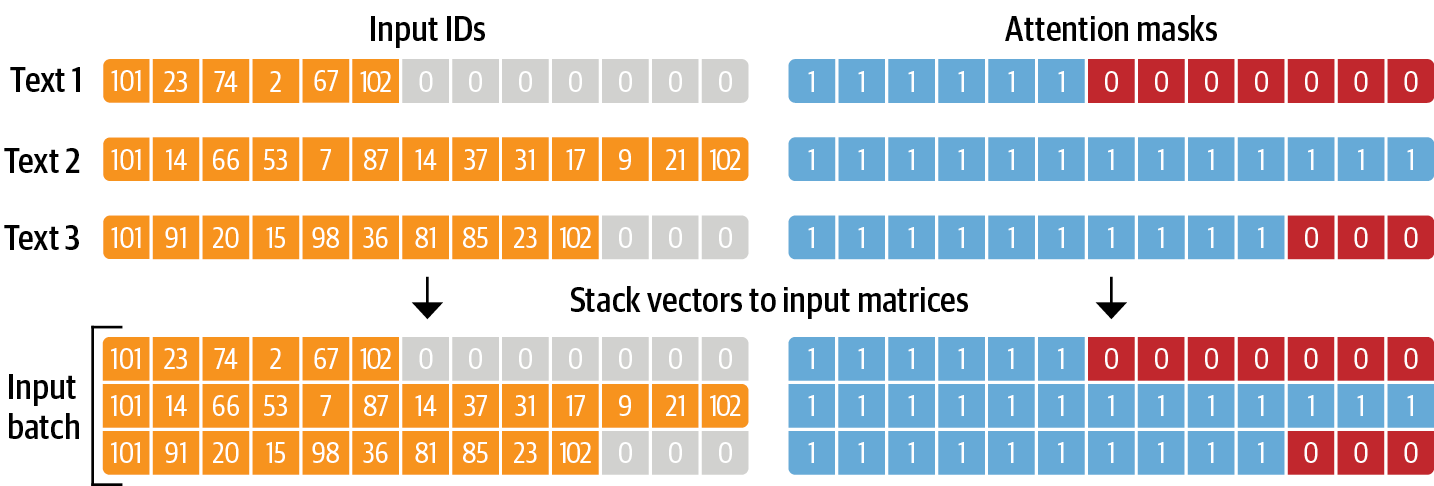



In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


---
# 텍스트 분류 모델 훈련하기

먼저 텍스트를 토큰화하여 원-핫 벡터로 나타낸다.  
그 다음 토큰 인코딩을 저차원 공간의 벡터인 토큰 임베딩으로 변환한다.  
그 다음 토큰 임베딩을 인코더 각 블록 층에 통과시켜 은닉상태로 만든다.  
각 은닉상태는 언어 모델링의 사전 훈련 목표를 달성하기 위해  
마스킹된 입력 토큰을 예측하는 층으로 전달된다.  


In [ ]:
# 사전 훈련된 모델 사용하기
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [ ]:
# 마지막 은닉 상태 추출하기
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


In [ ]:
# 마지막으로 모델이 있는 장치로 옮기고 입력으로 전달
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]),
hidden_states=None, attentions=None)


In [ ]:
# 마지막 은닉 상태의 크기 확인
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

6개의 입력 토큰 마다 768차원의 벡터가 반환되었다는 뜻

In [ ]:
# 문자열의 마지막 은닉 상태
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

전체 데이터 셋에서 같은 작업을 수행하고 모든 벡터를 저장해보자  
먼저 하나의 함수로 만들어야 한다.

In [ ]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

위 함수는 텐서가 입력되기를 기대하므로 input_ids와 attention_mask 열을  
"torch" 포맷으로 바꾼다.  

In [ ]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

이제 모든 분할에 대해 은닉상태를 한 번에 추출하자

In [ ]:
# 이 코드는 제대로 실행되지 않는다. 시간이 너무 오래걸림
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

시간이 꽤 오래걸렸다.  
무려 38분이나 걸렸다.  
이 코드는 시간이 너무 오래 걸리는 관계로 이후 내용은 책을 참조해서 작성했다.  
<br/>
이제 분류 모델을 훈련하자

# 특성 행렬 만들기

은닉 상태를 입력 특성으로 사용하고 레이블 타깃으로 사용해보자

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

# 훈련 세트 시각화

768차원의 은닉 상태를 시각화하는건 어렵기에 2D로 투영해보자

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련시킵니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.139915,6.209814,0
1,-3.131240,5.563813,0
2,5.098622,2.742911,3
3,-2.241736,3.330809,2
4,-3.356339,3.257922,3


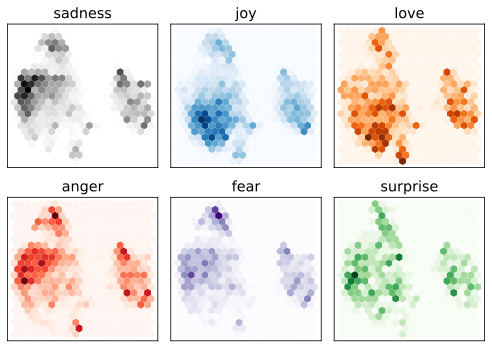

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

## 간단한 분류모델 훈련하기

사이킷런의 로지스틱 회귀 모델을 훈련해보자  
이런 간단한 모델은 훈련이 빠르고 GPU가 필요 없다.

In [ ]:
from sklearn.linear_model import LogisticRegression

# 수렴을 보장하기 위해 max_iter를 증가 시킨다.
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

이 모델은 정확도가 나쁘지 않다.  
다른 모델하고 한 번 비교해보자

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

보시다시피 이 모델보다 훨씬 점수가 높게 나온다.  

</br>

아무튼 이제 오차행렬을 살펴보자  
오차행렬은 진짜 레이블과 예측 레이블의 관계를 보여준다.

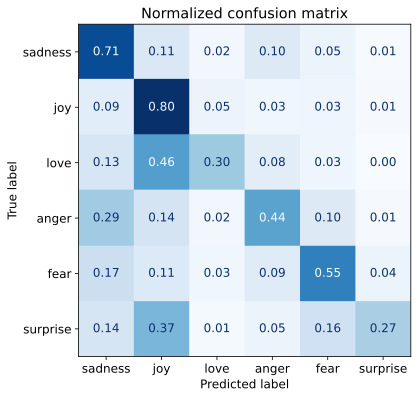

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

정규화된 오차 행렬  
anger와 fear는 sadness와 가장 많이 혼동된다.  
또 love와 surprise는 joy로 혼동된다.  

---

# 트랜스포머 미세 튜닝

트렌스포머를 엔드-투-엔드로 미세 튜닝하는 조건을 알아보자  
미세 튜닝 방식에서는 은닉 상태를 고정된 특성으로 사용하지 않고  
아래 그림처럼 전체 모델을 훈련한다.


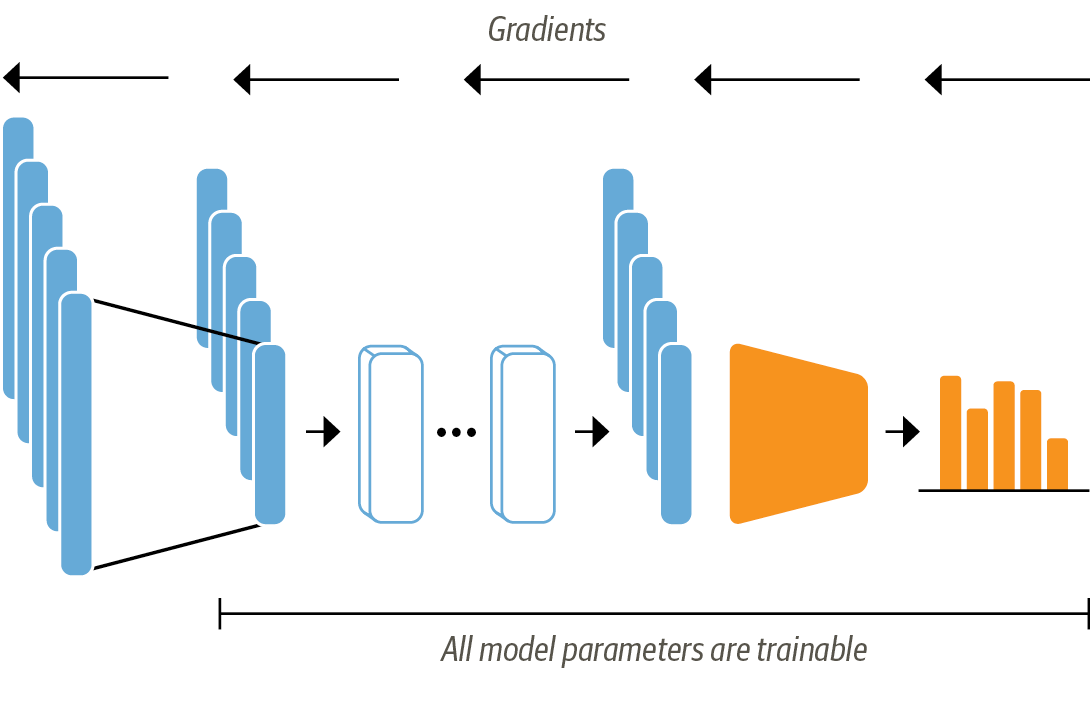

## 사전 훈련된 모델 불러오기
모델이 예측할 레이블 개수를 6개로 지정하자

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

## 성공 지표 정의하기
성능을 모니터링하기 위해 compute_metrics() 함수를 정의한다.  
다음처럼 모델 F1-점수와 정확도를 계산한다.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

데이터셋과 측정 지표가 준비되었다.  
단, 다음 두가지를 처리해야 한다.

```
허깅페이스 허브에 로그인하고 미세 튜닝한 모델을 허브 계정에 저장하고 커뮤에 공유
훈련을 위한 모든 하이퍼파라미터를 정의
```

이걸 다음 절에서 수행하자

## 모델 훈련하기

자, 이제 코드를 실행해 허브에 로그인하자

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

액세스 토큰을 입력하는 위젯이 나타났다. 액세스 토큰을 만드는 방법은  
https://oreil.ly/IRkN1 를 참고하자  
참고로 내 허깅페이스 이메일은 네이버, 비번은 구글에 있다.  
개인메뉴 -> 세팅에서 엑세스 토큰을 관리할 수 있다.  
참고로, 읽기용 토큰은 안 된다.


</br>

위의 위젯에 토큰을 입력하면 로그인이 된다.  

</br>

이제 훈련 파라미터를 정의하기 위해 TrainingArguments 클래스를 사용하자  
이 클래스는 많은 정보를 저장하며 훈련과 평가를 상세하게 제어한다.  
아래 클래스를 사용한 예시를 보자


In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

배치 크기, 학습률, 에포크 횟수도 설정하고 훈련이 끝난 후 최상의 모델을 로드하도록 지정했다.  
이런 설정으로 Trainer 객체를 만들고 모델을 미세 튜닝한다.  


In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/Tarel-HuggingFace/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.860700,0.326921,0.906500,0.903345
2,0.257500,0.223471,0.926500,0.926468


이거도 실행하는데 시간이 오래 걸린다.  
오차 행렬을 만들어 훈련 결과를 조금 더 상세히 살펴보자  
먼저 검증 세트에 대한 예측을 만들자

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

검증 세트에 대한 지표는 다음 코드로 확인한다.

In [ ]:
preds_output.metrics

{'test_loss': 0.22347082197666168,
 'test_accuracy': 0.9265,
 'test_f1': 0.9264675219632655,
 'test_runtime': 167.8756,
 'test_samples_per_second': 11.914,
 'test_steps_per_second': 0.191}

각 클래스에 대한 예측 데이터도 있다.  
np.argmax() 함수를 사용해 가장 큰 값이 나오도록 예측을 디코딩하자.

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

이 예측을 사용해 오차 행렬을 만들자

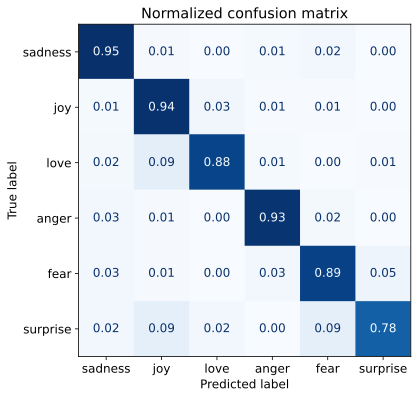

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

---

## 오류 분석

모델 예측을 조금 더 자세히 조사해보자  
정방향 패스 결과와 레이블을 사용하면 손실은 자동계산이다.  
다음은 손실과 예측 레이블을 반환하는 함수이다.  

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

다시 한번 map() 메서드로 이 함수를 적용해 모든 샘플의 손실을 구한다.

In [ ]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

마지막으로 텍스트, 손실, 예측 레이블과 진짜 레이블로 DataFrame을 만든다.  

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

### 잘못된 레이블

데이터에 레이블을 부여하는 프로세스는 모두 완벽하지 않다.  
레이블을 부여하는 에너테이터가 실수하거나 의견이 일치하지 않기도 한다.  
또 다른 특성에서 추론된 레이블이 틀리는 경우도 있다.  

### 데이터셋의 특이사항

실세계 데이터셋은 엉성하다.  
먼저 손실이 가장 높은 샘플을 확인해 보자

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.910603
1801,i feel that he was being overshadowed by the s...,love,sadness,5.495480
1950,i as representative of everything thats wrong ...,surprise,sadness,5.182331
1963,i called myself pro life and voted for perry w...,joy,sadness,5.083164
1274,i am going to several holiday parties and i ca...,joy,sadness,5.018039
1816,i am feeling overwhelmed i dont feel hopeless ...,surprise,sadness,4.937511
1683,i had applied for a job and they had assured m...,anger,joy,4.909647
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.807345
570,i don t mean this to be harsh selfish or uncar...,joy,anger,4.765707
465,i would eventually go in to these stores but i...,joy,fear,4.546636


모델이 일부 레이블을 잘못 예측했다.  
이번엔 가장 낮은 손실을 내는 예측도 살펴보자

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1622,i feel that it was a good investment to make t...,joy,joy,0.020915
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.020976
131,i feel like a graph doesnt show the data accur...,joy,joy,0.021020
578,i got to christmas feeling positive about the ...,joy,joy,0.021035
69,i have no extra money im worried all of the ti...,sadness,sadness,0.021057
1513,i have also been getting back into my gym rout...,joy,joy,0.021205
430,i have a feeling he would ve got something muc...,joy,joy,0.021342
604,i don t like to use the h word recklessly but ...,joy,joy,0.021371
1418,i am a big believer in the phrase that some pe...,joy,joy,0.021407
1976,i trust heavily when i feel that the trust is ...,joy,joy,0.021505


# 모델 저장 및 공유

누구나 허깅페이스 허브를 통해 다른 사람과 모델을 공유할 수 있다.  
공유해보자

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

To https://huggingface.co/Tarel-HuggingFace/distilbert-base-uncased-finetuned-emotion
   0742800..ad4015a  main -> main

   0742800..ad4015a  main -> main

To https://huggingface.co/Tarel-HuggingFace/distilbert-base-uncased-finetuned-emotion
   ad4015a..be340b0  main -> main

   ad4015a..be340b0  main -> main



'https://huggingface.co/Tarel-HuggingFace/distilbert-base-uncased-finetuned-emotion/commit/ad4015a7ebdc18da3cba05b8ae3cada75d039fc0'

모델을 허브에 업로드 했으니 이번엔 pipeline()을 만들어보자

In [ ]:
from transformers import pipeline

model_id = "Tarel-HuggingFace/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

샘플 트윗으로 이 파이프라인을 테스트 해보자

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


마지막으로 그래프로 나타내보자

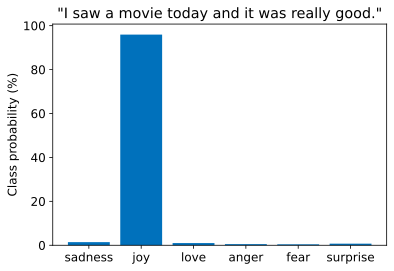

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()